# FFForge Workflow Development Notebook

In [22]:
# Required imports for development
from jobflow import Flow, Response, job, Maker, Job
from jobflow.utils.graph import to_mermaid
from jobflow.managers.local import run_locally
from jobflow.managers.fireworks import flow_to_workflow

from pymatgen.core import Structure, Lattice
from atomate2.vasp.jobs.core import StaticMaker
from pymatgen.io.cif import CifParser
from jinja2 import Template
from pathlib import Path
from collections import defaultdict
from dataclasses import field
from ase import Atoms
from openbabel import openbabel

import os
import pytest
import json

from jobflow.managers.fireworks import flow_to_workflow
from fireworks import LaunchPad, FWorker
from fireworks.queue.queue_launcher import launch_rocket_to_queue
from fireworks.core.rocket_launcher import launch_rocket
from fireworks.utilities.fw_serializers import load_object_from_file

In [23]:
# Ensure you're in ROOT_DIR/src/FFForge/api/nersc/ffforge by checking pwd
# Note: ROOT_DIR is PSCRATCH_DIR/FFForge
!pwd

/pscratch/sd/b/bfune/FFForge/wf_development_runs/5_13/launch_rocket_to_queue_run


In [24]:
# Define calc_dir in ROOT_DIR/wf_development_runs
calc_dir = "/pscratch/sd/b/bfune/FFForge/wf_development_runs"

## Generate Job

Code to develop the GENERATE job of the workflow

In [25]:
# different generators -> error handlers try execpt raiseerror
@job # TODO: make generate_rattled // generate_slab
def generate_rattled(
    structure_to_rattle: str | Path,
    purpose: str = "Simple Equilibration",
    num_structures: int = 20,
) -> list[Structure]:
    """Generate the rattled structures for the training set.

    Parameters
    ----------
    structure_to_rattle: str | Path
        The structure to rattled as a path
    purpose: str
        The purpose of generating the MLFF (TODO: list the allowed options). Default is Simple Equilibration
    num: int
        The number of rattled structures to generate.

    Returns
    -------
    rattled_strucutures: list[Structure]
        Rattled structures.
    """

    # TODO implement logic for purpose-dependent conditions:
        # if purpose=='DMA' -> ? -> structure = Structure object
        # if purpose=='Electrode depletion' -> ? -> structure = Structure object
        # if purpose=='Electrode analysis' -> ? -> structure = Structure object
        # if purpose=='Adsorption analysis' -> ? -> structure = Structure object
        # Psuedocode logic:
            # if not md_before (purpose means no MD needed before dft/ if no MD needed): 
            #   openbabel (convert current structure file to cif bc you dont have to worry about bonds - read documentation/chat)
            #   structure = Structure.from_str(open(structure_filename).read(), fmt="cif")
    
    rattled_structures = []
    # If purpose=='Simple equilibration' -> no MD needed -> openbabel -> structure = Structure
    if purpose == "Simple equilibration": 
        try:
            structure_to_rattle = Path(structure_to_rattle)  

            
            if structure_to_rattle.suffix[1:] != "cif":
                # Convert the input file to CIF format using Open Babel
                obConversion = openbabel.OBConversion()
                obConversion.SetInAndOutFormats(structure_to_rattle.suffix[1:], "cif")  # Extract format from file extension

                # Read structure file to object
                mol = openbabel.OBMol()
                if not obConversion.ReadFile(mol, str(structure_to_rattle)):
                    raise ValueError(f"Could not read structure file: {structure_to_rattle}")

                # Write structure file as cif file
                cif_path = structure_to_rattle.with_suffix(".cif")
                if not obConversion.WriteFile(mol, str(cif_path)):
                    raise ValueError(f"Could not convert {structure_to_rattle} to CIF format")

                # Read cif structure file
                structure = Structure.from_str(open(str(structure_to_rattle)).read(), fmt="cif")

                
                print('structure_to_rattle path is'+str(structure_to_rattle))
                print('cif path is'+str(cif_path))
                
                # cif_filename = os.path.basename(cif_path)
                # print('cif_filename is '+str(cif_filename))
                # print('curr dir is '+os.getcwd())
    
                
                # Read the CIF file into a pymatgen Structure object
                # structure = Structure.from_file(str(cif_path))
                # parser = CifParser(cif_path)
                # print("type of parser is"+type(parser))
                # 
                # structure = parser.parse_structures(primitive=True)[0]
                #structure = Structure.from_file(str(cif_path), fmt="cif")
    
                
                # # Generate rattled structures
                # for i in range(num_structures):
                #     # Determine standard deviation based on index
                #     std_dev = 0.005 if i < num_structures // 2 else 0.01
                #     # Create ASE Atoms object from pymatgen structure
                #     element_symbols = [site.specie.symbol for site in structure]
                #     atom_positions = structure.cart_coords
                #     atoms = Atoms(symbols=element_symbols, positions=atom_positions)
                #     # Apply random displacements using ASE's built-in 'rattle' function
                #     atoms.rattle(stdev=std_dev)
                #     # Convert back to pymatgen structure
                #     rattled_structure = Structure(
                #         lattice=structure.lattice,
                #         species=element_symbols,
                #         coords=atoms.get_positions(),
                #         site_properties=structure.site_properties,
                #     )
                #     rattled_structures.append(rattled_structure)
                # TODO: remove and uncomment^
            else:
                # Convert cif file path to Structure object
                structure = Structure.from_str(open(str(structure_to_rattle)).read(), fmt="cif")
            rattled_structures.append(structure)
            rattled_structures.append(structure)
            rattled_structures.append(structure)
                
        except Exception as e:
            print(f"An error occurred while generating rattled structures for simple equilibration: {e}")
            # Optionally, raise the error if you want it to halt the process
            raise e
    print(rattled_structures)
    return rattled_structures

#### Generate Tests

In [26]:
# Create mock structure for input
def mock_scf_structure():
    coords = [[0, 0, 0], [0.75, 0.5, 0.75]]
    lattice = Lattice.from_parameters(a=3.84, b=3.84, c=3.84, alpha=120, beta=90, gamma=60)
    struct = Structure(lattice, ["Si", "Si"], coords)
    return struct

In [27]:
# Create mock structure object
mock_structure=mock_scf_structure()

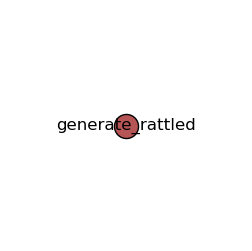

flowchart TD
    46a8ef29-09f2-4376-8787-8fdd26da382c(generate_rattled)


In [28]:
# Create the mock GENERATE job
test_structures_job = generate_rattled(mock_structure, num_structures=3, purpose="Simple equilibration")  
flow = Flow([test_structures_job])
flow.draw_graph(figsize=(3, 3)).show()
print(to_mermaid(flow))

In [29]:
# Convert flow to workflow (wf) and load to Launchpad
from fireworks import LaunchPad
from jobflow.managers.fireworks import flow_to_workflow

wf = flow_to_workflow(flow)
lpad = LaunchPad.auto_load()
lpad.add_wf(wf)

2025-05-13 15:06:11,716 INFO Added a workflow. id_map: {-2: 113}


{-2: 113}

In [30]:
# Launch the rocket using login node
from fireworks.core.rocket_launcher import launch_rocket
response = launch_rocket(lpad)

2025-05-13 15:06:11,726 INFO Launching Rocket
2025-05-13 15:06:11,767 INFO RUNNING fw_id: 113 in directory: /pscratch/sd/b/bfune/FFForge/wf_development_runs/5_13/launch_rocket_to_queue_run
2025-05-13 15:06:11,776 INFO Task started: {{jobflow.managers.fireworks.JobFiretask}}.
2025-05-13 15:06:11,777 INFO Starting job - generate_rattled (46a8ef29-09f2-4376-8787-8fdd26da382c)
An error occurred while generating rattled structures for simple equilibration: expected str, bytes or os.PathLike object, not Structure
2025-05-13 15:06:11,802 INFO Rocket finished


Traceback (most recent call last):
  File "/global/homes/b/bfune/.conda/envs/atomate2/lib/python3.10/site-packages/fireworks/core/rocket.py", line 261, in run
    m_action = t.run_task(my_spec)
  File "/global/homes/b/bfune/.conda/envs/atomate2/lib/python3.10/site-packages/jobflow/managers/fireworks.py", line 177, in run_task
    response = job.run(store=store)
  File "/global/homes/b/bfune/.conda/envs/atomate2/lib/python3.10/site-packages/jobflow/core/job.py", line 604, in run
    response = function(*self.function_args, **self.function_kwargs)
  File "/tmp/ipykernel_298308/1351164196.py", line 107, in generate_rattled
    raise e
  File "/tmp/ipykernel_298308/1351164196.py", line 39, in generate_rattled
    structure_to_rattle = Path(structure_to_rattle)
  File "/global/homes/b/bfune/.conda/envs/atomate2/lib/python3.10/pathlib.py", line 960, in __new__
    self = cls._from_parts(args)
  File "/global/homes/b/bfune/.conda/envs/atomate2/lib/python3.10/pathlib.py", line 594, in _from_pa

In [31]:
# Launch the flow locally on login node resources
response = run_locally(flow)

2025-05-13 15:06:11,810 INFO Started executing jobs locally
2025-05-13 15:06:11,812 INFO Starting job - generate_rattled (46a8ef29-09f2-4376-8787-8fdd26da382c)
An error occurred while generating rattled structures for simple equilibration: expected str, bytes or os.PathLike object, not Structure
2025-05-13 15:06:11,814 INFO generate_rattled failed with exception:
Traceback (most recent call last):
  File "/global/homes/b/bfune/.conda/envs/atomate2/lib/python3.10/site-packages/jobflow/managers/local.py", line 117, in _run_job
    response = job.run(store=store)
  File "/global/homes/b/bfune/.conda/envs/atomate2/lib/python3.10/site-packages/jobflow/core/job.py", line 604, in run
    response = function(*self.function_args, **self.function_kwargs)
  File "/tmp/ipykernel_298308/1351164196.py", line 107, in generate_rattled
    raise e
  File "/tmp/ipykernel_298308/1351164196.py", line 39, in generate_rattled
    structure_to_rattle = Path(structure_to_rattle)
  File "/global/homes/b/bfune/

## Run Job

Code to develop the RUN job of the workflow

In [32]:
@job # TODO: make run_scf_job // run_adslabs_job
def run_scf_job(
    scf_structures: list[Structure],
    static_maker: StaticMaker,
) -> Response:
    """Workflow of running the scf calculations.

    Parameters
    ----------
    scf_structures: list[Structure]
        The list of rattled strctures to run scf calculations on.
    static_maker: StaticMaker
        The static maker for the rattled structures.
    is_molecular: bool # TODO remove? could be the dict being called
        True if structure is a molecular structure, false if it is not (e.g. crystal)
    Returns
    -------
    Flow
        The flow of the scf calculations.
    """
    scf_jobs = []
    scf_outputs = defaultdict(list) # Output of the flow

    for i, scf_structure in enumerate(scf_structures):
        scf_job = static_maker.make(structure=scf_structure, prev_dir=None)
        scf_jobs.append(scf_job)
        scf_outputs["generated_hash"].append(scf_job.uuid) 
        scf_outputs["energy_in_eV"].append(scf_job.output.output.energy) 
        scf_outputs["sites"].append(scf_job.output.output.structure.sites) 
        scf_outputs["forces"].append(scf_job.output.output.forces) 
        scf_outputs["lattice_matrix"].append(scf_job.output.output.structure.lattice.matrix) 

    # Check types before creating Flow and Response
    # print(f"scf_jobs type: {type(scf_jobs)}")
    # print(f"scf_outputs type: {type(scf_outputs)}")

    # Ensure Flow is constructed correctly
    scf_flow = Flow(jobs=scf_jobs, output=scf_outputs)
    # print(f"scf_flow type: {type(scf_flow)}")

    return Response(replace=scf_flow)

#### Run Tests

#####  Mock objects

In [33]:
# Create mock input
def mock_scf_structure1():
    coords = [[0.1, 0.1, 0.1], [0.75, 0.5, 0.75]]
    lattice = Lattice.from_parameters(a=3.84, b=3.84, c=3.84, alpha=120, beta=90, gamma=60)
    struct = Structure(lattice, ["Si", "Si"], coords)
    return struct

def mock_scf_structure2():
    coords = [[0.2, 0.2, 0.2], [0.75, 0.5, 0.75]]
    lattice = Lattice.from_parameters(a=3.84, b=3.84, c=3.84, alpha=120, beta=90, gamma=60)
    struct = Structure(lattice, ["Si", "Si"], coords)
    return struct

def mock_scf_structure3():
    coords = [[0.3, 0.3, 0.3], [0.75, 0.5, 0.75]]
    lattice = Lattice.from_parameters(a=3.84, b=3.84, c=3.84, alpha=120, beta=90, gamma=60)
    struct = Structure(lattice, ["Si", "Si"], coords)
    return struct

mock_rattled_structures = [mock_scf_structure1(), mock_scf_structure2(), mock_scf_structure3()]
mock_static_maker = StaticMaker()

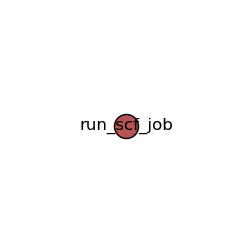

flowchart TD
    1f6d9a0a-ec9f-4c8a-9653-54cda22b7b4d(run_scf_job)


In [34]:
# Create the mock RUN job
test_run_job = run_scf_job(
    mock_rattled_structures, 
    static_maker=mock_static_maker
)  
test_run_flow = Flow([test_run_job])
test_run_flow.draw_graph(figsize=(3, 3)).show()
print(to_mermaid(test_run_flow))

In [ ]:
# Create run_calc_dir so outputs of the workflow can be run and stored here
run_calc_dir = calc_dir + "/5_13/run/launch_rocket_to_queue_run"

# Check if the directory exists, and create it if it doesn't
if not os.path.exists(run_calc_dir):
    os.makedirs(run_calc_dir)

# Change to the run directory
os.chdir(run_calc_dir)  # Important
!pwd

/pscratch/sd/b/bfune/FFForge/wf_development_runs/5_13/launch_rocket_to_queue_run


In [36]:
# Convert flow to workflow
# NOTE: Cannot use response = run_locally(flow) since we want to use computing power
test_run_wf = flow_to_workflow(test_run_flow)

##### Launch from Python's launch_rocket_to_queue

###### Instantiate launchpad

In [37]:
my_lpad= LaunchPad.from_file('/global/homes/b/bfune/fw_config/my_launchpad.yaml')

In [38]:
type(my_lpad)

fireworks.core.launchpad.LaunchPad

###### Instantiate qadapter

In [39]:
# Getting firework info from file
from fireworks.utilities.fw_serializers import load_object_from_file
my_qadapter = load_object_from_file("/global/homes/b/bfune/fw_config/my_qadapter.yaml")

In [40]:
type(my_qadapter)

fireworks.user_objects.queue_adapters.common_adapter.CommonAdapter

###### Instantiate fworker

In [41]:
my_fworker = FWorker.from_file('/global/homes/b/bfune/fw_config/my_fworker.yaml')

In [42]:
type(my_fworker)

fireworks.core.fworker.FWorker

###### Launch

In [43]:
my_mapping = my_lpad.add_wf(test_run_wf)

2025-05-13 15:06:12,317 INFO Added a workflow. id_map: {-3: 114}


In [ ]:
# Attempt to grab fw_id dynamically: NEVERMIND its not correct this generates FW
my_fw_id = my_mapping[1]
my_fw_id

In [ ]:
my_lpad.get_wf_by_fw_id(1).name

'Flow'

In [ ]:
# Important: run static job first to generate RUN fireworks, then run next
launch_rocket(my_lpad)

2025-01-06 19:28:39,909 INFO Launching Rocket
2025-01-06 19:28:39,943 INFO RUNNING fw_id: 1 in directory: /global/cfs/cdirs/m4537/bfune/mlff_runs/1_6/isolated_run
2025-01-06 19:28:39,977 INFO Task started: {{jobflow.managers.fireworks.JobFiretask}}.
2025-01-06 19:28:39,978 INFO Starting job - run_scf_job (dc22f181-c1bc-4bc0-8e56-346d14933fc5)
scf_jobs type: <class 'list'>
scf_outputs type: <class 'collections.defaultdict'>
scf_flow type: <class 'jobflow.core.flow.Flow'>
2025-01-06 19:28:40,542 INFO Finished job - run_scf_job (dc22f181-c1bc-4bc0-8e56-346d14933fc5)
2025-01-06 19:28:40,555 INFO Task completed: {{jobflow.managers.fireworks.JobFiretask}}
2025-01-06 19:28:40,646 INFO Rocket finished


True

In [ ]:
launch_rocket_to_queue(
    my_lpad,
    my_fworker,
    my_qadapter,
    reserve=True,
    launcher_dir=run_calc_dir,
    strm_lvl="DEBUG",
    fw_id=3) 

2025-01-06 19:31:19,667 DEBUG getting queue adapter
2025-01-06 19:31:19,675 DEBUG finding a FW to reserve...
2025-01-06 19:31:19,698 INFO reserved FW with fw_id: 3
2025-01-06 19:31:19,699 INFO moving to launch_dir /global/cfs/cdirs/m4537/bfune/mlff_runs/1_6/isolated_run
2025-01-06 19:31:19,699 DEBUG writing queue script
2025-01-06 19:31:19,702 INFO submitting queue script


'34639241'

In [ ]:
launch_rocket_to_queue(
    my_lpad,
    my_fworker,
    my_qadapter,
    reserve=True,
    launcher_dir=run_calc_dir,
    strm_lvl="DEBUG",
    fw_id=4) 

2025-01-06 19:31:39,322 DEBUG getting queue adapter
2025-01-06 19:31:39,330 DEBUG finding a FW to reserve...
2025-01-06 19:31:39,353 INFO reserved FW with fw_id: 4
2025-01-06 19:31:39,353 INFO moving to launch_dir /global/cfs/cdirs/m4537/bfune/mlff_runs/1_6/isolated_run
2025-01-06 19:31:39,354 DEBUG writing queue script
2025-01-06 19:31:39,355 INFO submitting queue script


'34639246'

In [ ]:
launch_rocket_to_queue(
    my_lpad,
    my_fworker,
    my_qadapter,
    reserve=True,
    launcher_dir=run_calc_dir,
    strm_lvl="DEBUG",
    fw_id=5) 

2025-01-06 19:31:52,874 DEBUG getting queue adapter
2025-01-06 19:31:52,880 DEBUG finding a FW to reserve...
2025-01-06 19:31:52,904 INFO reserved FW with fw_id: 5
2025-01-06 19:31:52,904 INFO moving to launch_dir /global/cfs/cdirs/m4537/bfune/mlff_runs/1_6/isolated_run
2025-01-06 19:31:52,905 DEBUG writing queue script
2025-01-06 19:31:52,906 INFO submitting queue script


'34639250'

##### Test for 'dict not callable'

In [ ]:
mock_run = run_scf_job(mock_rattled_structures)

# TEST: the job’s function object is of type dict when it should be of callable function
assert isinstance(mock_run, Job), "Expected mock_run to be of type jobflow.core.job.Job"
print(f"The type of mock_run is {type(mock_run)}, expected is jobflow.core.job.Job")

# Use callable to check if mock_run.function is callable
assert callable(mock_run.function), "Expected mock_run.function to be callable"
print(f"The type of mock_run.function is {type(mock_run.function)}, and it is callable")
print(f"The mock_run.function_kwargs is {mock_run.function_kwargs}")
print(f"The mock_run.function_args is {mock_run.function_args}")
#assert callable(mock_run), "mock_run is not callable"

# TEST: a dict type could be passed as the function's argument
print(f"The mock_run.function_args is {mock_run.function_args}")

print("asdfdasf")
mock_run.function_args[1]

The type of mock_run is <class 'jobflow.core.job.Job'>, expected is jobflow.core.job.Job
The type of mock_run.function is <class 'function'>, and it is callable
asdfasfd
The mock_run.function_kwargs is {}
The mock_run.function_args is ([Structure Summary
Lattice
    abc : 3.84 3.8399999999999994 3.84
 angles : 119.99999999999999 90.0 60.00000000000001
 volume : 40.038580810231124
      A : np.float64(3.84) np.float64(0.0) np.float64(2.351321854362918e-16)
      B : np.float64(1.92) np.float64(2.7152900397563426) np.float64(-1.919999999999999)
      C : np.float64(0.0) np.float64(0.0) np.float64(3.84)
    pbc : True True True
PeriodicSite: Si (0.576, 0.2715, 0.192) [0.1, 0.1, 0.1]
PeriodicSite: Si (3.84, 1.358, 1.92) [0.75, 0.5, 0.75], Structure Summary
Lattice
    abc : 3.84 3.8399999999999994 3.84
 angles : 119.99999999999999 90.0 60.00000000000001
 volume : 40.038580810231124
      A : np.float64(3.84) np.float64(0.0) np.float64(2.351321854362918e-16)
      B : np.float64(1.92) np.fl

IndexError: tuple index out of range

##### Launch from CLI's yaml

In [ ]:
# ! qlaunch -r singleshot

##### Launch from jobflow's run_locally

In [ ]:
# Create run_calc_dir so outputs of the workflow can be run and stored here
from jobflow import run_locally

run_calc_dir = calc_dir + "/5_13/run/run_locally_run"

# Check if the directory exists, and create it if it doesn't
if not os.path.exists(run_calc_dir):
    os.makedirs(run_calc_dir)

# Change to the run directory
os.chdir(run_calc_dir)  # Important
!pwd

In [ ]:
test_response = run_locally(test_run_flow)

2024-11-20 20:27:48,379 INFO Started executing jobs locally
2024-11-20 20:27:48,384 INFO Starting job - run_scf_job (4f5084b3-c4c7-49e5-9c85-21bb8f3679a2)
scf_jobs type: <class 'list'>
scf_outputs type: <class 'collections.defaultdict'>
scf_flow type: <class 'jobflow.core.flow.Flow'>
2024-11-20 20:27:48,950 INFO Finished job - run_scf_job (4f5084b3-c4c7-49e5-9c85-21bb8f3679a2)
2024-11-20 20:27:48,954 INFO Starting job - static (0453d9ae-a382-4db6-8149-203d4be4f126)


Failed to load vasprun.xml
Traceback (most recent call last):
  File "/global/homes/b/bfune/.conda/envs/atomate2/lib/python3.10/site-packages/custodian/vasp/validators.py", line 33, in check
    load_vasprun(os.path.join(directory, "vasprun.xml"))
  File "/global/homes/b/bfune/.conda/envs/atomate2/lib/python3.10/site-packages/custodian/utils.py", line 80, in __call__
    result = self.func(*args, **kwargs)
  File "/global/homes/b/bfune/.conda/envs/atomate2/lib/python3.10/site-packages/custodian/vasp/io.py", line 21, in load_vasprun
    return Vasprun(filepath, **vasprun_kwargs)
  File "/global/homes/b/bfune/.conda/envs/atomate2/lib/python3.10/site-packages/pymatgen/io/vasp/outputs.py", line 314, in __init__
    with zopen(filename, mode="rt") as file:
  File "/global/homes/b/bfune/.conda/envs/atomate2/lib/python3.10/site-packages/monty/io.py", line 54, in zopen
    return open(filename, *args, **kwargs)
FileNotFoundError: [Errno 2] No such file or directory: '/global/cfs/cdirs/m4537/bf

2024-11-20 20:27:59,105 INFO static failed with exception:
Traceback (most recent call last):
  File "/global/homes/b/bfune/.conda/envs/atomate2/lib/python3.10/site-packages/jobflow/managers/local.py", line 114, in _run_job
    response = job.run(store=store)
  File "/global/homes/b/bfune/.conda/envs/atomate2/lib/python3.10/site-packages/jobflow/core/job.py", line 600, in run
    response = function(*self.function_args, **self.function_kwargs)
  File "/global/homes/b/bfune/.conda/envs/atomate2/lib/python3.10/site-packages/atomate2/vasp/jobs/base.py", line 228, in make
    run_vasp(**self.run_vasp_kwargs)
  File "/global/homes/b/bfune/.conda/envs/atomate2/lib/python3.10/site-packages/atomate2/vasp/run.py", line 161, in run_vasp
    custodian_manager.run()
  File "/global/homes/b/bfune/.conda/envs/atomate2/lib/python3.10/site-packages/custodian/custodian.py", line 385, in run
    self._run_job(job_n, job)
  File "/global/homes/b/bfune/.conda/envs/atomate2/lib/python3.10/site-packages/cus

Failed to load vasprun.xml
Traceback (most recent call last):
  File "/global/homes/b/bfune/.conda/envs/atomate2/lib/python3.10/site-packages/custodian/vasp/validators.py", line 33, in check
    load_vasprun(os.path.join(directory, "vasprun.xml"))
  File "/global/homes/b/bfune/.conda/envs/atomate2/lib/python3.10/site-packages/custodian/utils.py", line 80, in __call__
    result = self.func(*args, **kwargs)
  File "/global/homes/b/bfune/.conda/envs/atomate2/lib/python3.10/site-packages/custodian/vasp/io.py", line 21, in load_vasprun
    return Vasprun(filepath, **vasprun_kwargs)
  File "/global/homes/b/bfune/.conda/envs/atomate2/lib/python3.10/site-packages/pymatgen/io/vasp/outputs.py", line 314, in __init__
    with zopen(filename, mode="rt") as file:
  File "/global/homes/b/bfune/.conda/envs/atomate2/lib/python3.10/site-packages/monty/io.py", line 54, in zopen
    return open(filename, *args, **kwargs)
FileNotFoundError: [Errno 2] No such file or directory: '/global/cfs/cdirs/m4537/bf

2024-11-20 20:28:09,248 INFO static failed with exception:
Traceback (most recent call last):
  File "/global/homes/b/bfune/.conda/envs/atomate2/lib/python3.10/site-packages/jobflow/managers/local.py", line 114, in _run_job
    response = job.run(store=store)
  File "/global/homes/b/bfune/.conda/envs/atomate2/lib/python3.10/site-packages/jobflow/core/job.py", line 600, in run
    response = function(*self.function_args, **self.function_kwargs)
  File "/global/homes/b/bfune/.conda/envs/atomate2/lib/python3.10/site-packages/atomate2/vasp/jobs/base.py", line 228, in make
    run_vasp(**self.run_vasp_kwargs)
  File "/global/homes/b/bfune/.conda/envs/atomate2/lib/python3.10/site-packages/atomate2/vasp/run.py", line 161, in run_vasp
    custodian_manager.run()
  File "/global/homes/b/bfune/.conda/envs/atomate2/lib/python3.10/site-packages/custodian/custodian.py", line 385, in run
    self._run_job(job_n, job)
  File "/global/homes/b/bfune/.conda/envs/atomate2/lib/python3.10/site-packages/cus

Failed to load vasprun.xml
Traceback (most recent call last):
  File "/global/homes/b/bfune/.conda/envs/atomate2/lib/python3.10/site-packages/custodian/vasp/validators.py", line 33, in check
    load_vasprun(os.path.join(directory, "vasprun.xml"))
  File "/global/homes/b/bfune/.conda/envs/atomate2/lib/python3.10/site-packages/custodian/utils.py", line 80, in __call__
    result = self.func(*args, **kwargs)
  File "/global/homes/b/bfune/.conda/envs/atomate2/lib/python3.10/site-packages/custodian/vasp/io.py", line 21, in load_vasprun
    return Vasprun(filepath, **vasprun_kwargs)
  File "/global/homes/b/bfune/.conda/envs/atomate2/lib/python3.10/site-packages/pymatgen/io/vasp/outputs.py", line 314, in __init__
    with zopen(filename, mode="rt") as file:
  File "/global/homes/b/bfune/.conda/envs/atomate2/lib/python3.10/site-packages/monty/io.py", line 54, in zopen
    return open(filename, *args, **kwargs)
FileNotFoundError: [Errno 2] No such file or directory: '/global/cfs/cdirs/m4537/bf

2024-11-20 20:28:19,415 INFO static failed with exception:
Traceback (most recent call last):
  File "/global/homes/b/bfune/.conda/envs/atomate2/lib/python3.10/site-packages/jobflow/managers/local.py", line 114, in _run_job
    response = job.run(store=store)
  File "/global/homes/b/bfune/.conda/envs/atomate2/lib/python3.10/site-packages/jobflow/core/job.py", line 600, in run
    response = function(*self.function_args, **self.function_kwargs)
  File "/global/homes/b/bfune/.conda/envs/atomate2/lib/python3.10/site-packages/atomate2/vasp/jobs/base.py", line 228, in make
    run_vasp(**self.run_vasp_kwargs)
  File "/global/homes/b/bfune/.conda/envs/atomate2/lib/python3.10/site-packages/atomate2/vasp/run.py", line 161, in run_vasp
    custodian_manager.run()
  File "/global/homes/b/bfune/.conda/envs/atomate2/lib/python3.10/site-packages/custodian/custodian.py", line 385, in run
    self._run_job(job_n, job)
  File "/global/homes/b/bfune/.conda/envs/atomate2/lib/python3.10/site-packages/cus

In [26]:
test_response

{'4f5084b3-c4c7-49e5-9c85-21bb8f3679a2': {1: Response(output=None, detour=None, addition=None, replace=Flow(name='Flow', uuid='3af42f67-c116-4be5-9935-632f3b5dad3b')
  1. Job(name='static', uuid='0453d9ae-a382-4db6-8149-203d4be4f126')
  2. Job(name='static', uuid='f079eb8e-f2c5-4688-a751-8f76d69d3d01')
  3. Job(name='static', uuid='563c7859-c061-4948-a553-ac18e4a17362')
  4. Job(name='store_inputs', uuid='4f5084b3-c4c7-49e5-9c85-21bb8f3679a2'), stored_data=None, stop_children=False, stop_jobflow=False, job_dir=None),
  2: Response(output=defaultdict(<class 'list'>, {'generated_hash': ['0453d9ae-a382-4db6-8149-203d4be4f126', 'f079eb8e-f2c5-4688-a751-8f76d69d3d01', '563c7859-c061-4948-a553-ac18e4a17362'], 'energy_in_eV': [OutputReference(0453d9ae-a382-4db6-8149-203d4be4f126, .output, .energy), OutputReference(f079eb8e-f2c5-4688-a751-8f76d69d3d01, .output, .energy), OutputReference(563c7859-c061-4948-a553-ac18e4a17362, .output, .energy)], 'sites': [OutputReference(0453d9ae-a382-4db6-8149-

## Write Job

Code to develop the WRITE job of the workflow

In [5]:
@job # TODO: make write_scf_examples // adsorption_calculations
def write_scf_examples(
    scf_data: dict[str, list], # This causes the values to be in a list, probably by design
    prefix: str = "Job",
    is_molecular: bool | str = False,
    output_dir: str | Path | None = None,
):
    """Write the example files from the scf calculations for PANNA usage.

    Parameters
    ----------
    scf_data : dict[str, list]
        Dictionary containing data of the scf calculations.
    prefix: str
        The identifier of the structure the forcefield is being generated for
    is_molecular: bool or str
        True if structure is a molecular structure, false if it is not (e.g. crystal)
    output_dir : str or Path or None
        A directory to output the example files for PANNA to use
    Returns
    -------
    None
    """

    lattice_vectors = {}
    site_results = []

    # Get output data
    generated_hash = scf_data["generated_hash"][0]
    energy_in_eV = scf_data["energy_in_eV"][0]
    sites = scf_data["sites"][0]
    forces = scf_data["forces"][0]
    output_dir = Path(f'./PANNA/examples_files') # TODO: change dir name from /PANNA/ -> /<fireworks_wf_id>_PANNA/
    
    # print("Type of generated_hash (ideal is string, might be list): ", type(generated_hash))
    # print("The generated_hash value: ", generated_hash)
    # print(f"Output directory: {output_dir}")
    # print(f"Data received: {scf_data}")

    # Process each site
    for i in range(len(sites)):
        
        site_dict = sites[i].as_dict(1)
        atom = site_dict["label"]
        xcoord, ycoord, zcoord = map(float, site_dict["xyz"])
        xforce, yforce, zforce = map(float, forces[0])

        # Append a dictionary with all relevant information
        site_results.append({
            "index": i,
            "atom": atom,
            "xcoord": xcoord,
            "ycoord": ycoord,
            "zcoord": zcoord,
            "xforce": xforce,
            "yforce": yforce,
            "zforce": zforce,
        })
        
    # If the structure is not molecular, get the lattice vector data
    if is_molecular is False:
        lattice_matrix = scf_data["lattice_matrix"][0]

        # Extract and cast the elements from the lattice matrix
        x1, x2, x3 = map(float, lattice_matrix[0])
        y1, y2, y3 = map(float, lattice_matrix[1])
        z1, z2, z3 = map(float, lattice_matrix[2])

        # Store lattice vectors as a single dictionary
        lattice_vectors = {
            "x1": x1,
            "x2": x2,
            "x3": x3,
            "y1": y1,
            "y2": y2,
            "y3": y3,
            "z1": z1,
            "z2": z2,
            "z3": z3
        }

    template_str = """{
    "key": "{{ generated_hash }}",{% if not is_molecular %}
    "lattice_vectors": [
        [
            {{ lattice_vectors['x1'] }},
            {{ lattice_vectors['x2'] }},
            {{ lattice_vectors['x3'] }}
        ],
        [
            {{ lattice_vectors['y1'] }},
            {{ lattice_vectors['y2'] }},
            {{ lattice_vectors['y3'] }}
        ],
        [
            {{ lattice_vectors['z1'] }},
            {{ lattice_vectors['z2'] }},
            {{ lattice_vectors['z3'] }}
        ]
    ],{% endif %}
    "atomic_position_unit": "cartesian",
    "unit_of_length": "angstrom",
    "energy": [
        {{ energy_in_eV }},
        "eV"
    ],
    "atoms": [{% for site in sites %}
        [
            {{ site['index'] }},
            "{{ site['atom'] }}",
            [
                {{ site['xcoord'] }},
                {{ site['ycoord'] }},
                {{ site['zcoord'] }}
            ],
            [
                {{ site['xforce'] }},
                {{ site['yforce'] }},
                {{ site['zforce'] }}
            ]
        ]{% if not loop.last %},{% endif %}{% endfor %}
    ]
}"""

    # Create the Jinja2 template object
    template = Template(template_str)

    # Render the template with provided arguments
    rendered_output = template.render(
        generated_hash=generated_hash,
        is_molecular=is_molecular,  # Convert to boolean
        lattice_vectors=lattice_vectors,
        energy_in_eV=energy_in_eV,
        sites=site_results
    )

    # Ensure the output directory exists
    output_dir.mkdir(parents=True, exist_ok=True)

    # Define the output file path
    output_file_path = output_dir / f"{prefix}_{generated_hash}.example"

    # Write the rendered output to the file
    with open(output_file_path, 'w') as f:
        f.write(rendered_output)

    print(f"Template written to {output_file_path}")

#### Write Tests

##### Mock objects

In [52]:
def mock_crystal_scf_data():
    return { # Put all key-values in a list to enforce scf_output style probably
        "generated_hash": ["mock_generated_hash_crystal_123"], 
        "energy_in_eV": [-10.5], 
        "sites": [
            [
                {
                    "label": "Mg",
                    "xyz": [0.0, 0.0, 0.0],
                    "species" : [
                        {
                            "element": "Mg",
                        }
                    ],
                },
                {
                    "label": "Mg",
                    "xyz": [1.0, 1.0, 1.0],
                    "species" : [
                        {
                            "element": "Mg",
                        }
                    ],
                },
            ],
        ],
        "forces": [
            [
                [0.1, 0.2, 0.3],
                [-0.1, -0.2, -0.3],
            ],
        ],
        "lattice_matrix": [ 
            [
                [1.0, 0.0, 0.0],
                [0.0, 1.0, 0.0],
                [0.0, 0.0, 1.0],
            ],
        ],
    }

In [53]:
def mock_molecular_scf_data():
    return {
        "generated_hash": [ "mock_generated_hash_molecular_123" ],
        "energy_in_eV": [ -10.5 ],
        "sites": [
            [
                {
                    "label": "H",
                    "xyz": [0.0, 0.0, 0.0],
                    "species" : [
                        {
                            "element": "H",
                        }
                    ],
                },
                {
                    "label": "O",
                    "xyz": [1.0, 1.0, 1.0],
                    "species" : [
                        {
                            "element": "O",
                        }
                    ],
                },
            ],
        ],
        "forces": [
            [
                [0.1, 0.2, 0.3],
                [-0.1, -0.2, -0.3],
            ],
        ],
    }

In [54]:
# Test for a crystal system
crystal_data = mock_crystal_scf_data()

# Test for a molecular system
molecular_data = mock_molecular_scf_data()

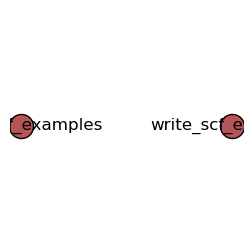

flowchart TD
    ef0989f2-17f3-4006-a559-2194016051f5(write_scf_examples)
    bd0369d3-dc68-4772-ac6a-33bfcadff286(write_scf_examples)


In [55]:
test_write_crystal_job = write_scf_examples(crystal_data, is_molecular=False)  
test_write_molecular_job = write_scf_examples(molecular_data, is_molecular=True)  
write_flow = Flow([test_write_crystal_job, test_write_molecular_job])
write_flow.draw_graph(figsize=(3, 3)).show()

print(to_mermaid(write_flow))

##### Execute via Jobflow (run_locally)

In [ ]:
# Create write_calc_dir so outputs of the workflow can be run and stored here
write_calc_dir = calc_dir + "/5_13/write/run_locally_run"

# Check if the directory exists, and create it if it doesn't
if not os.path.exists(write_calc_dir):
    os.makedirs(write_calc_dir)

# Change to the run directory
os.chdir(write_calc_dir)  # Important
!pwd

In [57]:
response = run_locally(write_flow)

2025-01-10 09:04:05,407 INFO Started executing jobs locally
2025-01-10 09:04:05,408 INFO Starting job - write_scf_examples (ef0989f2-17f3-4006-a559-2194016051f5)
Template written to PANNA/examples_files/Job_mock_generated_hash_crystal_123.example
2025-01-10 09:04:05,422 INFO Finished job - write_scf_examples (ef0989f2-17f3-4006-a559-2194016051f5)
2025-01-10 09:04:05,423 INFO Starting job - write_scf_examples (bd0369d3-dc68-4772-ac6a-33bfcadff286)
Template written to PANNA/examples_files/Job_mock_generated_hash_molecular_123.example
2025-01-10 09:04:05,431 INFO Finished job - write_scf_examples (bd0369d3-dc68-4772-ac6a-33bfcadff286)
2025-01-10 09:04:05,432 INFO Finished executing jobs locally


/global/homes/b/bfune/.conda/envs/atomate2/lib/python3.10/site-packages/jobflow/core/flow.py:431: UserWarning: Some jobs are not connected, their ordering may be random
  for node in itergraph(graph):


##### Execute via Fireworks (launch_rocket)

In [58]:
# Initialize lpad
lpad = LaunchPad.from_file('/global/homes/b/bfune/fw_config/my_launchpad.yaml')

In [59]:
# Add write workflow to launchpad 
write_wf = flow_to_workflow(write_flow) # Convert from Flow to Workflow
lpad.add_wf(write_wf)

2025-01-10 09:06:09,997 INFO Added a workflow. id_map: {-9: 6, -8: 7}


{-9: 6, -8: 7}

In [ ]:
# Create write_calc_dir so outputs of the workflow can be run and stored here
write_calc_dir = calc_dir + "/5_13/write/launch_rocket_run"

# Check if the directory exists, and create it if it doesn't
if not os.path.exists(write_calc_dir):
    os.makedirs(write_calc_dir)

# Change to the run directory
os.chdir(write_calc_dir)  # Important
!pwd

In [62]:
# Launch workflow
launch_rocket(lpad)

2025-01-10 09:06:42,539 INFO Launching Rocket
2025-01-10 09:06:42,560 INFO RUNNING fw_id: 7 in directory: /global/cfs/cdirs/m4537/bfune/mlff_runs/1_9/isolated_fireworks_write_fw
2025-01-10 09:06:42,569 INFO Task started: {{jobflow.managers.fireworks.JobFiretask}}.
2025-01-10 09:06:42,569 INFO Starting job - write_scf_examples (ef0989f2-17f3-4006-a559-2194016051f5)
Template written to PANNA/examples_files/Job_mock_generated_hash_crystal_123.example
2025-01-10 09:06:42,580 INFO Finished job - write_scf_examples (ef0989f2-17f3-4006-a559-2194016051f5)
2025-01-10 09:06:42,580 INFO Task completed: {{jobflow.managers.fireworks.JobFiretask}}
2025-01-10 09:06:42,597 INFO Rocket finished


True

## MLForceFieldMaker Workflow

Code to develop the workflow called MLForceFieldMaker (connecting GENERATE, RUN, WRITE)

In [75]:
"""Flow for writing example files for a structure to use with PANNA surface."""

from dataclasses import dataclass
from jobflow import Flow, Job, Maker
from pymatgen.core.structure import Structure
from atomate2.vasp.jobs.core import StaticMaker
from pathlib import Path
# TODO: import the functions from job.py

@dataclass
class MLForceFieldMaker(Maker):
    """
    Workflow that writes example files from SCF calculated, rattled structures.

    The flow consists of the following steps:
      1. Generate rattled structures
      2. Run scf vasp calculations on the generated structures
      3. Write example files to a specified directory

    Parameters
    ----------
    name: str
        Name of the flow.
    examples_dir : str or Path or None
        A directory to output the example files for PANNA to use
    """

    name: str = "forge force field workflow"
    static_maker: Maker = field(default_factory=StaticMaker)
    example_dir: str | Path | None = Path(f'./PANNA/examples_files') # TODO: change dir name from /PANNA/ -> /<fireworks_wf_id>_PANNA/

    def make(
        self,
        structure: str | Path, 
        prefix: str = "Job",
        max_structures: int = 20,
        is_molecular: bool = False,
        purpose: str = "Simple Equilibration",
        use_custodian: bool = True
    ) -> Flow:
        """
        Generate a flow for writing example files for rattled scf structures.

        Parameters
        -----------
        structure: str | Path
            A string or Path to a structure file. The structure to be generate a MLFF for.
        prefix: str
            The identifier of the structure the forcefield is being generated for.
        max_structures: int or 20
            Number of structures to rattled to make the PANNA training set off of.
        example_dir: str or Path or None
            A directory to output the example files to.
        is_molecular: bool
            True if structure is a molecular structure, False if it is not (e.g. crystal systems)
        use_custodian: bool
            True if user wants to use custodian when running VASP (recommended), else False to run VASP without custodian
        Returns
        --------
        Flow
            A flow object for writing the example files
        """
        
        # If custodian is not used, set `job_type` to `direct`
        if not use_custodian:
            self.static_maker.run_vasp_kwargs["job_type"] = "direct"

        jobs: list[Job] = []

        # Step 1: Generate rattled structures
        generate_rattled_structures = generate_rattled(
            structure_to_rattle = structure,
            purpose = 'Simple Equilibration',
            num_structures = max_structures,
        )
        jobs += [generate_rattled_structures]
        rattled_structures = generate_rattled_structures.output

        # Step 2: Run SCF calculations on rattled structures
        run_scf_calculation = run_scf_job( 
            scf_structures=rattled_structures,
            static_maker=self.static_maker,
        )
        jobs +=  [run_scf_calculation]
        scf_outputs = run_scf_calculation.output

        # Step 3: Write example files to the specified directory
        write_example_files = write_scf_examples(
            scf_data=scf_outputs,
            prefix=prefix,
            is_molecular=is_molecular,
            output_dir=self.example_dir,
        )
        jobs += [write_example_files]

        return Flow(
            jobs=jobs,
            output=write_example_files.output,
            name = self.name,
        )

### Flow Tests

##### Mock objects

In [76]:
def mock_wf_structure():
    coords = [[0.33, 0.33, 0.33], [0.75, 0.5, 0.75]]
    lattice = Lattice.from_parameters(a=3.84, b=3.84, c=3.84, alpha=120, beta=90, gamma=60)
    struct = Structure(lattice, ["Si", "Si"], coords)
    return struct

In [77]:
mock_structure = mock_wf_structure()
mock_prefix = "Mock_Wf_Whole_Test_6"
mock_max_structures = 3
mock_is_molecular = False
mock_purpose = "Simple Equilibration"

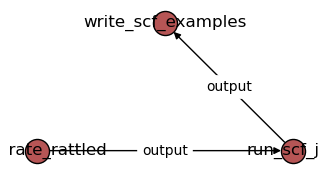

flowchart TD
    3907d69f-4a17-4492-a6e2-befcb125c446(generate_rattled) -->|output| 6a72d338-6d1e-4c63-b39f-0994e29c1619(run_scf_job)
    6a72d338-6d1e-4c63-b39f-0994e29c1619(run_scf_job) -->|output| 5fd6ea83-33f3-4f53-b33b-1a442204f3b9(write_scf_examples)
    3907d69f-4a17-4492-a6e2-befcb125c446(generate_rattled)
    6a72d338-6d1e-4c63-b39f-0994e29c1619(run_scf_job)
    5fd6ea83-33f3-4f53-b33b-1a442204f3b9(write_scf_examples)


In [78]:
# Create an instance of MLForceFieldMaker
mlff_maker = MLForceFieldMaker()

# Call make on the instance
mlff_flow = mlff_maker.make(
    structure=mock_structure,
    prefix=mock_prefix,
    max_structures=mock_max_structures,
    is_molecular=mock_is_molecular,
    purpose=mock_purpose
)

# Now, you can use the created workflow as before
mlff_flow.draw_graph(figsize=(4, 2)).show()
print(to_mermaid(mlff_flow))

In [79]:
mlff_flow

Flow(name='forge force field workflow', uuid='16c8b0d4-270c-45ee-b3db-77d76db7bb92')
1. Job(name='generate_rattled', uuid='3907d69f-4a17-4492-a6e2-befcb125c446')
2. Job(name='run_scf_job', uuid='6a72d338-6d1e-4c63-b39f-0994e29c1619')
3. Job(name='write_scf_examples', uuid='5fd6ea83-33f3-4f53-b33b-1a442204f3b9')

##### Test via Jobflow (run_locally)

In [ ]:
# Create wf_calc_dir so outputs of the workflow can be run and stored here
wf_calc_dir = calc_dir + "/5_13/wf/run_locally_run"

# Check if the directory exists, and create it if it doesn't
if not os.path.exists(write_calc_dir):
    os.makedirs(write_calc_dir)

# Change to the run directory
os.chdir(write_calc_dir)  # Important
!pwd

In [ ]:
# Run the flow locally
mlff_response = run_locally(mlff_flow)

2025-01-21 11:34:53,061 INFO Started executing jobs locally
2025-01-21 11:34:53,065 INFO Starting job - generate_rattled (dfa0ccc3-d351-45f4-b99c-a5c9f6f540c5)
[Structure Summary
Lattice
    abc : 3.84 3.8399999999999994 3.84
 angles : 119.99999999999999 90.0 60.00000000000001
 volume : 40.038580810231124
      A : np.float64(3.84) np.float64(0.0) np.float64(2.351321854362918e-16)
      B : np.float64(1.92) np.float64(2.7152900397563426) np.float64(-1.919999999999999)
      C : np.float64(0.0) np.float64(0.0) np.float64(3.84)
    pbc : True True True
PeriodicSite: Si (1.901, 0.896, 0.6336) [0.33, 0.33, 0.33]
PeriodicSite: Si (3.84, 1.358, 1.92) [0.75, 0.5, 0.75], Structure Summary
Lattice
    abc : 3.84 3.8399999999999994 3.84
 angles : 119.99999999999999 90.0 60.00000000000001
 volume : 40.038580810231124
      A : np.float64(3.84) np.float64(0.0) np.float64(2.351321854362918e-16)
      B : np.float64(1.92) np.float64(2.7152900397563426) np.float64(-1.919999999999999)
      C : np.flo

/global/homes/b/bfune/.conda/envs/atomate2/lib/python3.10/site-packages/pymatgen/io/vasp/inputs.py:2420: EncodingWarning: We strongly encourage explicit `encoding`, and we would use UTF-8 by default as per PEP 686
  with zopen(filename, mode="rt") as file:
/global/homes/b/bfune/.conda/envs/atomate2/lib/python3.10/site-packages/pymatgen/io/vasp/inputs.py:2985: EncodingWarning: We strongly encourage explicit `encoding`, and we would use UTF-8 by default as per PEP 686
  with zopen(os.path.join(output_dir, key), mode="wt") as file:
/global/homes/b/bfune/.conda/envs/atomate2/lib/python3.10/site-packages/pymatgen/io/vasp/inputs.py:908: EncodingWarning: We strongly encourage explicit `encoding`, and we would use UTF-8 by default as per PEP 686
  with zopen(filename, mode="rt") as file:
/global/homes/b/bfune/.conda/envs/atomate2/lib/python3.10/site-packages/custodian/vasp/handlers.py:185: EncodingWarning: We strongly encourage explicit `encoding`, and we would use UTF-8 by default as per PEP 

2025-01-21 11:35:59,232 INFO Finished job - static (bb9f97ab-da61-4df9-ae57-a2bb04ebc812)
2025-01-21 11:35:59,232 WARNING Response.stored_data is not supported with local manager.
2025-01-21 11:35:59,233 INFO Starting job - static (995a6ada-3891-4a43-affa-a3f8ab771420)


/global/homes/b/bfune/.conda/envs/atomate2/lib/python3.10/site-packages/pymatgen/io/vasp/inputs.py:2420: EncodingWarning: We strongly encourage explicit `encoding`, and we would use UTF-8 by default as per PEP 686
  with zopen(filename, mode="rt") as file:
/global/homes/b/bfune/.conda/envs/atomate2/lib/python3.10/site-packages/pymatgen/io/vasp/inputs.py:2985: EncodingWarning: We strongly encourage explicit `encoding`, and we would use UTF-8 by default as per PEP 686
  with zopen(os.path.join(output_dir, key), mode="wt") as file:


KeyboardInterrupt: 

##### Test via Fireworks (launch_rocket & launch_rocket_to_queue)

In [80]:
# Convert Flow to Workflow
mlff_wf = flow_to_workflow(mlff_flow)

In [81]:
mlff_wf.name

'forge force field workflow'

In [ ]:
# To add metadata
mlff_wf.metadata["hash_id_test"] = "meeting_run"

In [83]:
mlff_wf.metadata

{'hash_id_test': 'meeting_run'}

In [ ]:
# Create wf_calc_dir so outputs of the workflow can be run and stored here
wf_calc_dir = calc_dir + "/5_13/wf/launch_fw_run"

# Check if the directory exists, and create it if it doesn't
if not os.path.exists(write_calc_dir):
    os.makedirs(write_calc_dir)

# Change to the run directory
os.chdir(write_calc_dir)  # Important: change to working directory
!pwd

In [2]:
# Initialize launch objects
mlff_lpad = LaunchPad.from_file('/global/homes/b/bfune/fw_config/my_launchpad.yaml')
mlff_fworker = FWorker.from_file('/global/homes/b/bfune/fw_config/my_fworker.yaml')
mlff_qadapter = load_object_from_file("/global/homes/b/bfune/fw_config/my_qadapter.yaml")

In [17]:
# Query fws of wfs based on metadata.workflow_id
mlff_lpad.get_fw_ids_in_wfs(wf_query={"metadata.workflow_id": "67cd15f7c407a6edfdcd6f79"})

[13, 14, 15, 16, 17, 18]

In [19]:
# Query root fw of wf based on lpad
root_id_list = mlff_lpad.get_wf_ids(query={"metadata.workflow_id": "67cd15f7c407a6edfdcd6f79"})
root_id = root_id_list[0]
print(root_id)

13


In [22]:
# Query links of wf
mlff_lpad.get_wf_by_fw_id(root_id).links

{13: [], 14: [13, 17, 18], 15: [14], 16: [13], 17: [16], 18: [16]}

In [32]:
# Query states of wf
wf_states = mlff_lpad.get_wf_by_fw_id(root_id).fw_states
wf_states

{13: 'WAITING',
 14: 'COMPLETED',
 15: 'COMPLETED',
 16: 'WAITING',
 17: 'READY',
 18: 'READY'}

In [33]:
# Filter READY fws
wf_ready_states= {fw_id: state for fw_id, state in wf_states.items() if state=='READY'}
print(wf_ready_states)

{17: 'READY', 18: 'READY'}


In [ ]:
# Launch all READY fws
for fw_id, state in wf_ready_states:
    # Submit job to queue
    launch_rocket_to_queue(
        mlff_lpad,
        mlff_fworker,
        mlff_qadapter,
        reserve=True,
        launcher_dir=wf_calc_dir,
        strm_lvl="DEBUG",
        fw_id=fw_id) 

In [86]:
# Important: reset lpad
mlff_fw_id_map = mlff_lpad.add_wf(mlff_wf) # Add workflow to launchpad

2025-01-21 12:18:14,304 INFO Added a workflow. id_map: {-12: 18, -11: 19, -10: 20}


In [87]:
mlff_fw_id_map

{-12: 18, -11: 19, -10: 20}

In [104]:
mlff_wf.root_fw_ids

[20]

In [106]:
mlff_lpad.get_wf_by_fw_id(20).links

{18: [], 19: [18, 22, 23], 20: [19], 21: [18], 22: [21], 23: [21]}

In [ ]:
for fw_id, state in mlff_wf.fw_states.items():
    if state == 'READY':
        # Submit job to queue
        launch_rocket_to_queue(
            mlff_lpad,
            mlff_fworker,
            mlff_qadapter,
            reserve=True,
            launcher_dir=wf_calc_dir,
            strm_lvl="DEBUG",
            fw_id=fw_id) # TODO: dynamically determine value, right now, there should only be 1 static job to submit to queue

2025-01-21 12:12:50,159 DEBUG getting queue adapter
2025-01-21 12:12:50,166 DEBUG finding a FW to reserve...
2025-01-21 12:12:50,183 INFO reserved FW with fw_id: 17
2025-01-21 12:12:50,183 INFO moving to launch_dir /global/cfs/cdirs/m4537/bfune/mlff_runs/1_21/fws_run
2025-01-21 12:12:50,184 DEBUG writing queue script
2025-01-21 12:12:50,188 INFO submitting queue script


In [31]:
run_fw_id = list(mlff_fw_id_map.values())[1]  # This gets the value of the second pair (2 in this case)
print(f"Run FW id: {run_fw_id}")

Run FW id: 10


In [89]:
# Launch locally
launch_rocket(mlff_lpad, fw_id=20)

2025-01-21 12:18:32,363 INFO Launching Rocket
2025-01-21 12:18:32,383 INFO RUNNING fw_id: 20 in directory: /global/cfs/cdirs/m4537/bfune/mlff_runs/1_21/fws_run_2
2025-01-21 12:18:32,391 INFO Task started: {{jobflow.managers.fireworks.JobFiretask}}.
2025-01-21 12:18:32,392 INFO Starting job - generate_rattled (3907d69f-4a17-4492-a6e2-befcb125c446)
[Structure Summary
Lattice
    abc : 3.84 3.8399999999999994 3.84
 angles : 119.99999999999999 90.0 60.00000000000001
 volume : 40.038580810231124
      A : np.float64(3.84) np.float64(0.0) np.float64(2.351321854362918e-16)
      B : np.float64(1.92) np.float64(2.7152900397563426) np.float64(-1.919999999999999)
      C : np.float64(0.0) np.float64(0.0) np.float64(3.84)
    pbc : True True True
PeriodicSite: Si (1.901, 0.896, 0.6336) [0.33, 0.33, 0.33]
PeriodicSite: Si (3.84, 1.358, 1.92) [0.75, 0.5, 0.75], Structure Summary
Lattice
    abc : 3.84 3.8399999999999994 3.84
 angles : 119.99999999999999 90.0 60.00000000000001
 volume : 40.038580810

True

In [90]:
# Launch locally
launch_rocket(mlff_lpad, fw_id=19)

2025-01-21 12:18:41,678 INFO Launching Rocket
2025-01-21 12:18:41,704 INFO RUNNING fw_id: 19 in directory: /global/cfs/cdirs/m4537/bfune/mlff_runs/1_21/fws_run_2
2025-01-21 12:18:41,714 INFO Task started: {{jobflow.managers.fireworks.JobFiretask}}.
2025-01-21 12:18:41,715 INFO Starting job - run_scf_job (6a72d338-6d1e-4c63-b39f-0994e29c1619)
2025-01-21 12:18:42,100 INFO Finished job - run_scf_job (6a72d338-6d1e-4c63-b39f-0994e29c1619)
2025-01-21 12:18:42,109 INFO Task completed: {{jobflow.managers.fireworks.JobFiretask}}
2025-01-21 12:18:42,177 INFO Rocket finished


True

In [34]:
# Run after RUN has ran
# Dynamically determine how many times to run rapidfire
updated_ids = mlff_wf.refresh(run_fw_id)
print(f"Refreshed Firework IDs: {updated_ids}")


Refreshed Firework IDs: set()


In [22]:
print(f"Refreshed Firework IDs: {len(updated_ids)}")


Refreshed Firework IDs: 0


In [40]:
mlff_wf.links

{11: [10], 10: [9], 9: []}

In [55]:
mlff_lpad.get_wf_summary_dict

[1, 8, 9]

In [23]:
print("# TODO: once Ricardo finishes generate_rattled implementation, dynamically determine how many jobs to submit to queue with mlff_fw_id_map and mock_max_structures")
print("In development, should be 1 static job submitted to queue.")
print("In production, should be max_structures static job(s) submitted to queue")
print(f"mlff_fw_id_map is {mlff_fw_id_map}")
print(f"mock_max_structures is {mock_max_structures}")

# TODO: once Ricardo finishes generate_rattled implementation, dynamically determine how many jobs to submit to queue with mlff_fw_id_map and mock_max_structures
In development, should be 1 static job submitted to queue.
In production, should be max_structures static job(s) submitted to queue
mlff_fw_id_map is {-3: 1, -2: 2, -1: 3}
mock_max_structures is 3


In [26]:
# Submit job to queue
launch_rocket_to_queue(
    mlff_lpad,
    mlff_fworker,
    mlff_qadapter,
    reserve=True,
    launcher_dir=calc_dir,
    strm_lvl="DEBUG",
    fw_id=5) # TODO: dynamically determine value, right now, there should only be 1 static job to submit to queue

2025-01-12 19:11:19,139 DEBUG getting queue adapter
2025-01-12 19:11:19,149 DEBUG finding a FW to reserve...
2025-01-12 19:11:19,180 INFO reserved FW with fw_id: 5
2025-01-12 19:11:19,181 INFO moving to launch_dir /global/cfs/cdirs/m4537/bfune/mlff_runs/1_12/whole_fireworks_wf
2025-01-12 19:11:19,182 DEBUG writing queue script
2025-01-12 19:11:19,184 INFO submitting queue script


'34801874'

## Deactivate custodian tests in MLForceFieldMaker

In [6]:
from atomate2.vasp.jobs.base import BaseVaspMaker
from jobflow.utils import ValueEnum

In [21]:
test_base_maker = BaseVaspMaker(run_vasp_kwargs={"job_type": "direct"})

In [19]:
test_base_job = test_base_maker.as_dict

In [20]:
test_base_job

<bound method MSONable.as_dict of BaseVaspMaker(name='base vasp job', input_set_generator=VaspInputGenerator(structure=None, config_dict={'PARENT': 'VASPIncarBase', 'INCAR': {'ALGO': 'Fast', 'EDIFF': 1e-05, 'EDIFFG': -0.02, 'ENAUG': 1360, 'ENCUT': 680, 'IBRION': 2, 'ISIF': 3, 'ISMEAR': 0, 'ISPIN': 2, 'LAECHG': True, 'LASPH': True, 'LCHARG': True, 'LELF': False, 'LMIXTAU': True, 'LORBIT': 11, 'LREAL': False, 'LVTOT': True, 'LWAVE': False, 'NELM': 200, 'NSW': 99, 'PREC': 'Accurate', 'SIGMA': 0.05, 'MAGMOM': {'Ce': 5, 'Ce3+': 1, 'Co': 0.6, 'Co3+': 0.6, 'Co4+': 1, 'Cr': 5, 'Dy3+': 5, 'Er3+': 3, 'Eu': 10, 'Eu2+': 7, 'Eu3+': 6, 'Fe': 5, 'Gd3+': 7, 'Ho3+': 4, 'La3+': 0.6, 'Lu3+': 0.6, 'Mn': 5, 'Mn3+': 4, 'Mn4+': 3, 'Mo': 5, 'Nd3+': 3, 'Ni': 5, 'Pm3+': 4, 'Pr3+': 2, 'Sm3+': 5, 'Tb3+': 6, 'Tm3+': 2, 'V': 5, 'W': 5, 'Yb3+': 1}, 'GGA': 'PS', 'LDAU': True, 'LDAUJ': {'F': {'Co': 0, 'Cr': 0, 'Fe': 0, 'Mn': 0, 'Mo': 0, 'Ni': 0, 'V': 0, 'W': 0}, 'O': {'Co': 0, 'Cr': 0, 'Fe': 0, 'Mn': 0, 'Mo': 0, 'Ni':

## Unit tests 

TODO